In [10]:

!pip install qiskit-aer

In [11]:
!pip install qiskit_algorithms

In [12]:
!pip install pylatexenc

In [13]:
!pip3 install qiskit

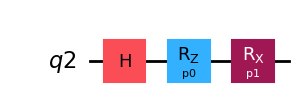

In [124]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
import numpy as np

# Instantiate the quantum circuit
p0 = Parameter("p0")
p1 = Parameter("p1")
q = QuantumRegister(1)
qc = QuantumCircuit(q)
qc.h(q)
qc.rz(p0, q[0])
qc.rx(p1, q[0])

display(qc.draw("mpl"))

# Instantiate the Hamiltonian observable 2X+Z
H = SparsePauliOp.from_list([("X", 2), ("Z", 1)])

X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

H = 2 * X + Z
# Parameter list
params = [[np.pi / 4, 0]]

qc.assign_parameters({p0: np.pi / 4, p1: 0})


In [41]:
from qiskit_aer import Aer
from qiskit import transpile

#result = execute(qc, Aer.get_backend('statevector_simulator')).result()

def state_vector(qc, params):
  for i in range(len(params)): # assign each parameter.
    qc = qc.assign_parameters({"p" + str(i) : params[i]})

  new_circuit = transpile(qc, Aer.get_backend('statevector_simulator'))
  return Aer.get_backend('statevector_simulator').run(new_circuit).result().get_statevector().data

def expectation_value(qc, params, H):
  for i in range(len(params)): # assign each parameter.
    qc = qc.assign_parameters({"p" + str(i) : params[i]})


  new_circuit = transpile(qc, Aer.get_backend('statevector_simulator'))
  state_vector = Aer.get_backend('statevector_simulator').run(new_circuit).result().get_statevector()

  return np.real(np.vdot(state_vector.data, H @ state_vector.data))

In [27]:

 np.random.randn(8)

array([ 0.10100433, -0.05128119, -0.70574121, -1.86347043,  1.66775634,
       -0.40464185,  0.19305059,  0.55106816])

In [49]:
np.array([np.pi/4] * 8)

array([0.78539816, 0.78539816, 0.78539816, 0.78539816, 0.78539816,
       0.78539816, 0.78539816, 0.78539816])

In [67]:
calc_qfi(qc, np.array([np.pi/4] * 8))

array([[ 1.00000000e+00, -1.11920473e-11,  6.75364876e-12,
         1.33180523e-12,  3.53553391e-01,  3.82454957e-12,
         2.50000000e-01,  7.57627294e-12],
       [-1.11920473e-11,  1.00000000e+00, -5.27304151e-12,
        -5.58511827e-12, -3.53553391e-01,  5.00000000e-01,
         2.50000000e-01,  5.00000000e-01],
       [ 6.75364876e-12, -5.27304151e-12,  5.00000000e-01,
         4.91295893e-12, -1.76776695e-01,  2.50000000e-01,
         4.78553391e-01,  2.50000000e-01],
       [ 1.33180523e-12, -5.58511827e-12,  4.91295893e-12,
         5.00000000e-01, -1.76776695e-01, -2.50000000e-01,
         1.25000000e-01,  5.00000000e-01],
       [ 3.53553391e-01, -3.53553391e-01, -1.76776695e-01,
        -1.76776695e-01,  9.37500000e-01, -4.41941738e-01,
        -8.08058262e-02, -1.76776695e-01],
       [ 3.82454957e-12,  5.00000000e-01,  2.50000000e-01,
        -2.50000000e-01, -4.41941738e-01,  8.75000000e-01,
        -1.07233047e-02,  7.57485564e-12],
       [ 2.50000000e-01,  2.500000

In [66]:
def calc_qfi(qc, params, eps=1e-5):
  state_grads = calc_state_grads(qc, params)

  k = len(params)

  state = state_vector(qc, params)

  qfi = np.zeros((k, k))
  for i in range(k):
    for j in range(k):

            term1 = np.vdot(state_grads[i], state_grads[j])
            term2 = np.vdot(state_grads[i], state) * np.vdot(state, state_grads[j])
            qfi[i, j] = 4 * np.real(term1 - term2)

  return qfi

In [64]:
# for fubini study metric
def calc_state_grads(qc, params, eps=1e-5):

  grads = np.zeros((len(params), len(state_vector(qc, params))), dtype=np.complex128)

  for i in range(len(params)):
    params_plus = params.copy()
    params_plus[i] += eps


    state_vector_plus = state_vector(qc, params_plus)

    params_minus = params.copy()
    params_minus[i] -= eps

    state_vector_minus = state_vector(qc, params_minus)
    partial = (state_vector_plus - state_vector_minus) / (2 * eps)
    grads[i] = partial


  return grads

In [20]:
def calc_grads(qc, params, H, eps=1e-5):

  grads = np.zeros(len(params))

  for i in range(len(params)):
    params_plus = params.copy()
    params_plus[i] += eps


    expectation_plus = expectation_value(qc, params_plus, H)

    params_minus = params.copy()
    params_minus[i] -= eps
    expectation_minus = expectation_value(qc, params_minus, H)
    partial = (expectation_plus - expectation_minus) / (2 * eps)
    grads[i] = partial


  return grads

In [134]:
eps = 1e-5

from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import FiniteDiffEstimatorGradient

estimator = Estimator()
state_grad = FiniteDiffEstimatorGradient(estimator, epsilon=eps)

# Evaluate the gradient
H = SparsePauliOp.from_list([("X", 2), ("Z", 1)])
fde_grad_result = state_grad.run(qc, H, params).result().gradients
print("State estimator gradient computed with finite difference", fde_grad_result)

State estimator gradient computed with finite difference [array([-1.41421356,  0.70710678])]


<ipython-input-134-65188be2d4e6>:6: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [126]:
#params = np.random.rand(len(qc.parameters))
params = [np.pi/4, np.pi/4]
calc_hessians(qc, params, H)

array([[-1.91421767,  0.49999838],
       [ 0.49999838, -0.50001336]])

In [72]:
def calc_hessians(qc, params, H, eps=1e-5):
  k = len(params)
  hessians = np.zeros((k, k))

  # for i in range(k):
  #   for j in range(k):
  #     if(i == j):
  #       params_plus = params.copy()
  #       params_plus[i] += eps

  #       params_minus = params.copy()
  #       params_minus[i] -= eps
  #       expectation_minus = expectation_value(qc, params_minus, H)


  expectation = expectation_value(qc, params, H)
  for i in range(k):
    for j in range(k):
      if(i == j):
        params_plus = params.copy()
        params_plus[i] += eps

        expectation_plus = expectation_value(qc, params_plus, H)

        params_minus = params.copy()
        params_minus[i] -= eps
        expectation_minus = expectation_value(qc, params_minus, H)

        #expectation = expectation_value(qc, params, H)

        hessians[i][j] = (expectation_plus - 2 * expectation + expectation_minus) / (eps**2)
        #if(np.abs(hessians[i][j]) < 1e-2): hessians[i][j] = 0

      else:
        params_plus_i_minus_j = params.copy()
        params_plus_i_minus_j[i] += eps
        params_plus_i_minus_j[j] -= eps

        expectation_plus_i_minus_j = expectation_value(qc, params_plus_i_minus_j, H)

        params_minus_i_plus_j = params.copy()
        params_minus_i_plus_j[i] -= eps
        params_minus_i_plus_j[j] += eps
        expectation_minus_i_plus_j = expectation_value(qc, params_minus_i_plus_j, H)


        params_plus_ij = params.copy()
        params_plus_ij[i] += eps
        params_plus_ij[j] += eps
        expectation_plus_ij = expectation_value(qc, params_plus_ij, H)

        params_minus_ij = params.copy()
        params_minus_ij[i] -= eps
        params_minus_ij[j] -= eps
        expectation_minus_ij = expectation_value(qc, params_minus_ij, H)


        hessians[i][j] = (expectation_plus_ij - expectation_plus_i_minus_j - expectation_minus_i_plus_j + expectation_minus_ij) / (4 * eps**2)

  # return hessians

  return hessians

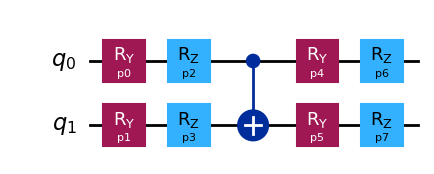

In [16]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
import numpy as np

# Instantiate the system Hamiltonian
# Define Pauli matrices
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

# Define the Hamiltonian as a sum of tensor products
H = (
    -1.05 * np.kron(I, I)
    + 0.39 * np.kron(I, Z)
    - 0.39 * np.kron(Z, I)
    - 0.01 * np.kron(Z, Z)
    + 0.18 * np.kron(X, X)
)

# This is the target energy
h2_energy = -1.85727503

# Define the Ansatz
wavefunction = QuantumCircuit(2)
# params = ParameterVector('theta', length=8)
# it = iter(params)
p0 = Parameter("p0")
p1 = Parameter("p1")
p2 = Parameter("p2")
p3 = Parameter("p3")
p4 = Parameter("p4")
p5 = Parameter("p5")
p6 = Parameter("p6")
p7 = Parameter("p7")


wavefunction.ry(p0, 0)
wavefunction.ry(p1, 1)
wavefunction.rz(p2, 0)
wavefunction.rz(p3, 1)
wavefunction.cx(0, 1)
wavefunction.ry(p4, 0)
wavefunction.ry(p5, 1)
wavefunction.rz(p6, 0)
wavefunction.rz(p7, 1)

qc = wavefunction

display(qc.draw("mpl"))

In [78]:
def quantum_natural_gradient_descent(qc, lr=1, epochs=100):

  params = np.random.uniform(0, 2 * np.pi, size=8)

  for i in range(epochs):
    grads = calc_grads(qc, params, H, eps=1e-5)
    qfi = calc_qfi(qc, params, eps=1e-5)

    # eigvals, eigvecs = np.linalg.eigh(hessians)
    # inv_hessian = eigvecs @ np.diag(1.0 / np.maximum(eigvals, 1e-5)) @ eigvecs.T

    params -= lr * np.linalg.pinv(qfi).dot(grads)


    print("Current expectation value:")
    print(expectation_value(qc, params, H))

quantum_natural_gradient_descent(qc, 1)

Current expectation value:
-1.355464889814734
Current expectation value:
-1.5900881754451688
Current expectation value:
-1.7284842145578563


KeyboardInterrupt: 

In [79]:
def newtons_method(qc, lr=1, epochs=100):

  params = np.random.uniform(0, 2 * np.pi, size=8)

  for i in range(epochs):
    grads = calc_grads(qc, params, H, eps=1e-5)
    hessians = calc_hessians(qc, params, H, eps=1e-5)

    # eigvals, eigvecs = np.linalg.eigh(hessians)
    # inv_hessian = eigvecs @ np.diag(1.0 / np.maximum(eigvals, 1e-5)) @ eigvecs.T

    params -= lr * np.matmul(np.linalg.pinv(hessians), grads)


    print("Current expectation value:")
    print(expectation_value(qc, params, H))

newtons_method(qc, 1)

Current expectation value:
-0.7111754762207158
Current expectation value:
-0.909063025565489
Current expectation value:
-0.9763924955846672
Current expectation value:
-1.1547360573303131
Current expectation value:
-1.2359910898266586
Current expectation value:
-1.0078033521275087
Current expectation value:
-1.1956431212903327
Current expectation value:
-0.9594868377689343


KeyboardInterrupt: 

In [114]:
def gradient_descent(qc, lr=1, epochs=100):
  epoch = 100
  params = np.random.rand(len(qc.parameters))
  #params = [np.pi/4 ,0]
  for i in range(epochs):
    grads = calc_grads(qc, params, H, eps=1e-5)
    params -= lr * grads
    print("Current expectation value:")
    print(expectation_value(qc, params, H))

gradient_descent(qc)

Current expectation value:
-0.9803982533117397
Current expectation value:
-1.0610015831387523
Current expectation value:
-1.1550730436942853
Current expectation value:
-1.278265549456568
Current expectation value:
-1.4210429715529593
Current expectation value:
-1.5632127494116028
Current expectation value:
-1.6860519061187356
Current expectation value:
-1.7655868800695156
Current expectation value:
-1.8029983249563717
Current expectation value:
-1.819829355259987
Current expectation value:
-1.828578172945442
Current expectation value:
-1.8335346432658255
Current expectation value:
-1.8364145749138276
Current expectation value:
-1.8380969316538025
Current expectation value:
-1.8390792842099868


KeyboardInterrupt: 

In [17]:
eps = 1e-5

from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import FiniteDiffEstimatorGradient

estimator = Estimator()
state_grad = FiniteDiffEstimatorGradient(estimator, epsilon=eps)

# Evaluate the gradient
H = SparsePauliOp.from_list([("X", 2), ("Z", 1)])
fde_grad_result = state_grad.run(qc, H, params).result().gradients
print("State estimator gradient computed with finite difference", fde_grad_result)

State estimator gradient computed with finite difference [array([-1.41421356,  0.70710678])]


<ipython-input-17-65188be2d4e6>:6: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
